# A/B Тест Отчет

## Введение
В этом отчете представлены результаты A/B-теста, проведенного для анализа результатов совпадений между различными группами пользователей в приложении для знакомств. Набор данных содержит информацию о парах пользователей и о том, привели ли они к совпадению. Цель состоит в том, чтобы определить, существует ли значительная разница в показателях совпадений между двумя группами.

## Описание данных

В данных находится выгрузка логов взаимодействия пользователей друг с другом. Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч.

Набор данных, используемый для этого анализа, включает следующие столбцы:
- `user_id_1`: ID первого пользователя в паре
- `user_id_2`: ID второго пользователя в паре
- `group`: Идентификатор группы (0 или 1)
- `is_match`: Результат мэтча (0 — нет мэтча, 1 — мэтч)

## Разведочный анализ данных

Для начала загрузим данные и проведем первоначальное исследование, чтобы понять их структуру и содержание.

In [1]:
import pandas as pd
from scipy.stats import ttest_ind, chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [2]:
def read_file(href: str, parse_dates=None) -> pd.DataFrame:
    """
    Функция возвращает считанный датафрейм по публичной ссылке на файл.
    
    :param href: Публичная ссылка на файл
    :param parse_dates: Список колонок, которые нужно преобразовать в даты
    :return: DataFrame, считанный из файла
    """
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    final_url = f"{base_url}public_key={href}"
    response = requests.get(final_url)
    
    download_url = response.json()['href']
    
    return pd.read_csv(download_url, parse_dates=parse_dates)

In [3]:
dating_app = read_file('https://disk.yandex.ru/d/txn7q-CE2zSaPg')

In [4]:
dating_app.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [5]:
dating_app.describe()

,user_id_1,user_id_2,group,is_match
count,14514.000000,14514.000000,14514.000000,14514.000000
mean,500.220132,501.843737,0.669836,0.333678
std,288.703825,287.250879,0.470288,0.471542
min,1.000000,1.000000,0.000000,0.000000
25%,253.000000,255.000000,0.000000,0.000000
50%,504.000000,500.000000,1.000000,0.000000
75%,751.000000,752.750000,1.000000,1.000000
max,1000.000000,1000.000000,1.000000,1.000000


In [6]:
dating_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14514 entries, 0 to 14513
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id_1  14514 non-null  int64
 1   user_id_2  14514 non-null  int64
 2   group      14514 non-null  int64
 3   is_match   14514 non-null  int64
dtypes: int64(4)
memory usage: 453.7 KB


## Статистический анализ

Чтобы оценить, правда ли, что новый алгоритм улучшил качество сервиса необходимо провести статистический анализ. 

Составим гипотезы для теста:

### Гипотезы для хи-квадрат теста

**Нулевая гипотеза (𝐻₀):**
Нет зависимости между использованием алгоритма (группа 0 или группа 1) и наличием мэтча (мэтч или нет). Процент мэтчей в обеих группах одинаков.

**Альтернативная гипотеза (𝐻₁):**
Есть зависимость между использованием алгоритма (группа 0 или группа 1) и наличием мэтча (мэтч или нет). Процент мэтчей в одной из групп значимо отличается от другой.


### Гипотезы для t-теста

**Нулевая гипотеза (𝐻₀):**
Среднее количество мэтчей на пользователя в группе 0 (старый алгоритм) равно среднему количеству мэтчей на пользователя в группе 1 (новый алгоритм).

𝐻₀: μ₀ = μ₁

**Альтернативная гипотеза (𝐻₁):**
Среднее количество мэтчей на пользователя в группе 0 (старый алгоритм) не равно среднему количеству мэтчей на пользователя в группе 1 (новый алгоритм).

𝐻₁: μ₀ ≠ μ₁

# Chi-squared test для процента мэтчей:

В нашем случае, хи-квадрат тест проверяет, существует ли значимая связь между двумя категориальными переменными – группой (0 или 1) и фактом мэтча (1 или 0).
Результат указывает на то, есть ли статистически значимая разница в пропорциях мэтчей между двумя группами.

In [7]:
contingency_table = pd.crosstab(dating_app['group'], dating_app['is_match'])
chi2_stat, p_val, dof, ex = chi2_contingency(contingency_table)

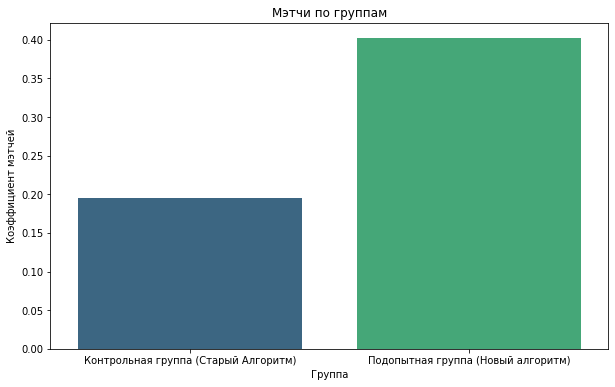

In [8]:
match_rates = dating_app.groupby('group')['is_match'].mean()

plt.figure(figsize=(10, 6))

sns.barplot(x=match_rates.index, y=match_rates.values, palette="viridis")
plt.title('Мэтчи по группам')
plt.xlabel('Группа')
plt.ylabel('Коэффициент мэтчей')
plt.xticks(ticks=[0, 1], labels=['Контрольная группа (Старый Алгоритм)', 'Подопытная группа (Новый алгоритм)'])
plt.show()

In [9]:
chi2_stat, p_val, 

(618.6889141576198, 1.4418299163662586e-136)

χ2: 618.69
    
p-значение: очень маленькое
    
это p-значение значительно ниже любого обычного уровня значимости (например, 0.05), что **подтверждает, что различия в долях мэтчей между двумя группами статистически значимы.**

# T-test для среднего количества мэтчей на пользователя:

В нашем случае, t-тест сравнивает среднее количество мэтчей на пользователя между двумя группами.

Результат указывает на то, есть ли статистически значимая разница в средних значениях (количестве мэтчей на пользователя) между двумя группами.

In [10]:
matches_per_user = dating_app.groupby(['group', 'user_id_1']).agg({'is_match': 'sum'}).reset_index()

matches_per_user_group0 = matches_per_user[matches_per_user['group'] == 0]['is_match'].mean()
matches_per_user_group1 = matches_per_user[matches_per_user['group'] == 1]['is_match'].mean()

t_stat, p_value = ttest_ind(matches_per_user_group0, matches_per_user_group1, equal_var=False)

print("Среднее количество мэтчей на пользователя в группе 0:", matches_per_user_group0)
print("Среднее количество мэтчей на пользователя в группе 1:", matches_per_user_group1)

Среднее количество мэтчей на пользователя в группе 0: 1.8642714570858283
Среднее количество мэтчей на пользователя в группе 1: 7.833667334669339


/opt/tljh/user/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/tljh/user/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


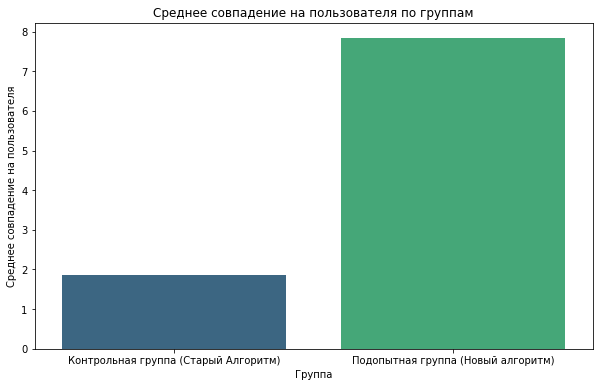

In [11]:
plt.figure(figsize=(10, 6))

sns.barplot(x=['Контрольная группа (Старый Алгоритм)', 'Подопытная группа (Новый алгоритм)'], 
            y=[matches_per_user_group0, matches_per_user_group1], palette="viridis")
plt.xlabel('Группа')
plt.ylabel('Среднее совпадение на пользователя')
plt.title('Среднее совпадение на пользователя по группам')
plt.show()

Значение t-статистики: -47.13

p-значение: 2.129646275434177e-229

Отрицательное значение t-статистики указывает на то, что **среднее количество совпадений** на пользователя в тестовой группе 1 (с новым алгоритмом) **выше, чем в контрольной группе**. P-значение подтверждает, что это различие статистически значимо.

## Результат

Результаты статистического анализа усиливают выводы, сделанные на основе описательного анализа: **новый алгоритм значительно улучшил качество** сервиса в приложении для онлайн-знакомств, увеличив количество мэтчей. Следует включить новую систему поиска анкет на всех пользователей